In [1]:
### REFORMAT TO ONLY INCLUDE REQUIRED FUNCTIONS ###
import pandas as pd
import numpy as np
import numpy
import sklearn
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
import statsmodels
import math
import matplotlib as mpl
## Import 'helper_functions.py' from the folder 'functions'
# import functions.helper_functions as custom_functions
# from functions.helper_functions import *
# import Libraries.Objects.Group as G
from pandas import Series
from statsmodels.tsa.arima_model import ARIMA
from pandas import datetime
import warnings
from pandas import read_csv
from pandas import datetime
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error


In [2]:
# Take in command line arguments
import time

print('------------------FORECASTER------------------')
x = input('Please type the name of the historical data file (include .csv):')
print ('Ok, computing forecast...')
time.sleep(3)
FILE_NAME = str(x)

------------------FORECASTER------------------
Please type the name of the historical data file (include .csv):k
Ok, computing forecast...


In [3]:
## Read in file
# filepath = r'.historical_data.csv'
filepath = 'dataset.csv'
site_id = 'Site Number'
utilization = '% Utilization'
date = 'Date'
# filepath = '.historical_data.csv'
na_values = ['.......']

# Read in data
csv = pd.read_csv(filepath, usecols=[site_id, utilization, date], dtype={site_id : int , utilization : float}, index_col=date, na_values = na_values, )
csv.loc[:, utilization] = csv.loc[:, utilization].fillna(csv.loc[:, utilization].mean())

In [4]:
# Set index type as DataTime for later processing
csv.index = pd.to_datetime(csv.index)

In [5]:
#
## Group sites according to their Unique Identifier ##
#

# Global Variables #
cell_sites = csv.groupby(site_id)
num_cell_sites = len(cell_sites)
minimume_size = 104
num_predictions = 52
counter = 0
weeks = []
week = "week_"
accuracy = "percent_error"

columns = []
results_dict = {}
results_dict[site_id] = []

# Create the week columns 
for i in range(1,num_predictions+1):
    col_name = week + str(i)
    # Creating dictionary that will be printed to csv file
    results_dict[col_name] = []
    weeks.append(col_name)
results_dict[accuracy] = []

# Name the columns for ouput file
columns.append(site_id)
columns.extend(weeks)
columns.append(accuracy)

model_results_csv = pd.DataFrame(columns=columns)

In [7]:
# Create a differenced series (Y = X(n) - X(n-1))
def difference(dataset, interval=1):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval] ## NEW
        diff.append(value)
    return numpy.array(diff)

# Responsible for applying log(x) to the difference
## of elements in a dataset
def log_difference(dataset, interval=1):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
        return numpy.array(diff)

# Invert differenced value : Used to transform the 
## time series dataset into a stationary dataset
## so it may be accurately processed by the ARIMA model.
def inverse_difference(history, yhat, interval=1):
    invers_result = yhat + history[-interval] ## NEW
    return invers_result

# Invert log differenced value : Used in the process
## of making the timeseries dataset stationary
def inverse_log_difference(history, yhat, interval=1):
    return yhat + history[-interval]

In [8]:
# Evaluate an ARIMA model for a given order (p,d,q)
def evaluate_arima_model(X, arima_order):
    # prepare training dataset
    train_size = int(len(X) * 0.66)
    train, test = X[0:train_size], X[train_size:]
    history = [x for x in train]
    # make predictions
    predictions = list()
    for t in range(len(test)):
        model = ARIMA(history, order=arima_order)
        model_fit = model.fit(disp=0)
        yhat = model_fit.forecast()[0]
        predictions.append(yhat)
        history.append(test[t])
    # calculate out of sample error
    error = mean_squared_error(test, predictions)
    return error


# Evaluate combinations of p, d and q values for an ARIMA model
## useful for automating the processes of (p,d,q) selection
def evaluate_models(dataset, p_values, d_values, q_values):
    dataset = dataset.astype('float32')
    best_score, best_cfg = float("inf"), None
    for p in p_values:
        for d in d_values:
            for q in q_values:
                order = (p,d,q)
                try:
                    mse = evaluate_arima_model(dataset, order)
                    if mse < best_score:
                        best_score, best_cfg = mse, order
                    # Uncomment to print the current (p,d,q) values
                    # print('ARIMA%s MSE=%.3f' % (order,mse))
                except:
                    continue
    # Uncomment to print values of (p,d,q) for the most accurate model
    # print('Best ARIMA%s MSE=%.3f' % (best_cfg, best_score))
    return best_cfg, best_score

In [19]:
def create_plot(history, historic_data, site_identifier):
    ## Plot visual customization
    plt.figure(figsize=(14,8))
    plt.style.use('dark_background')
    plt.title(site_identifier)
    plt.ylabel('% utilization')
    plt.xlabel('week number')
    plt.grid('off')
    plt.ylim(0,100)
    plt.plot(history, color='cyan', label='future prediction')
    plt.plot(historic_data.loc[:, utilization].values.tolist(), color='w')
    plt.plot(np.exp(X), color='orange',label='past data')
    plt.legend()
    plt.savefig('Site_' + str(site_identifier) + '.png')
    plt.show()

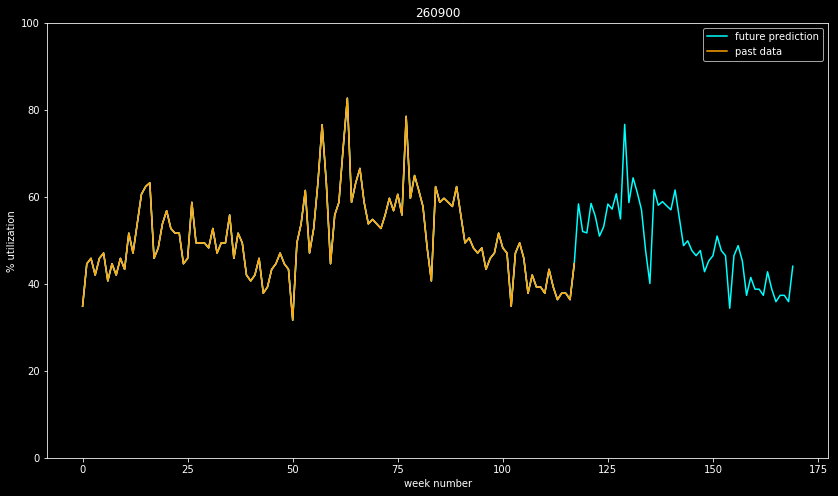

Error of model # 1  =  0.029960579079804543


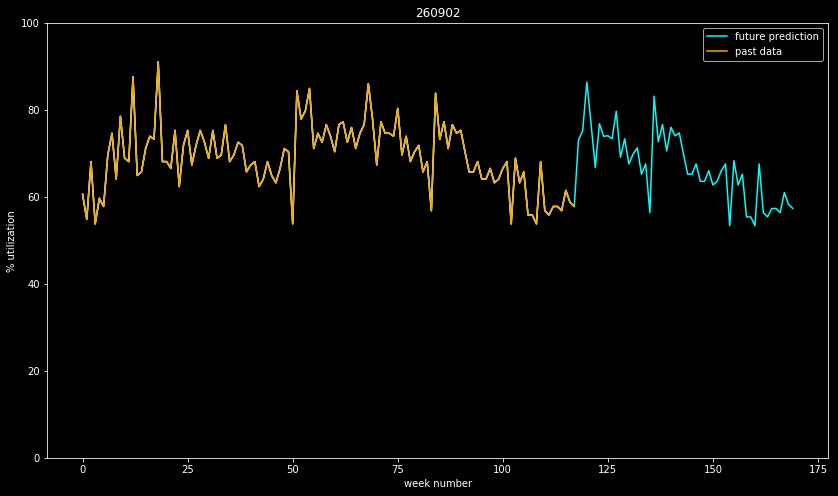

Error of model # 2  =  0.008915554132687848


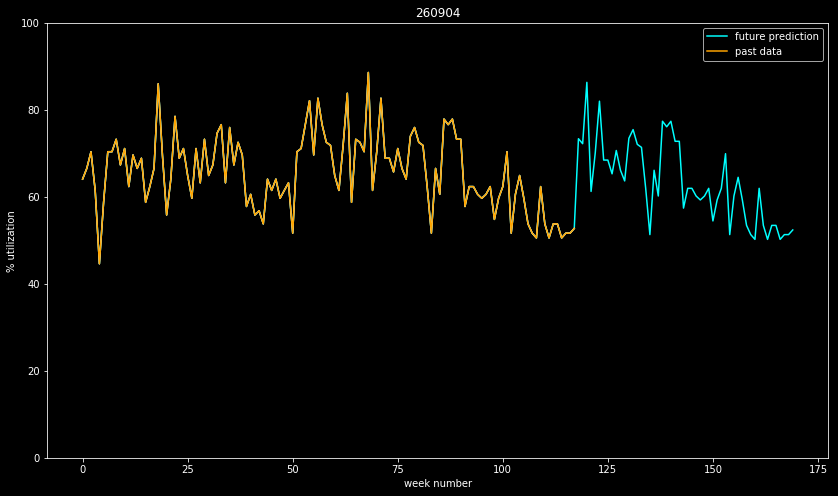

Error of model # 3  =  0.01993898689224891


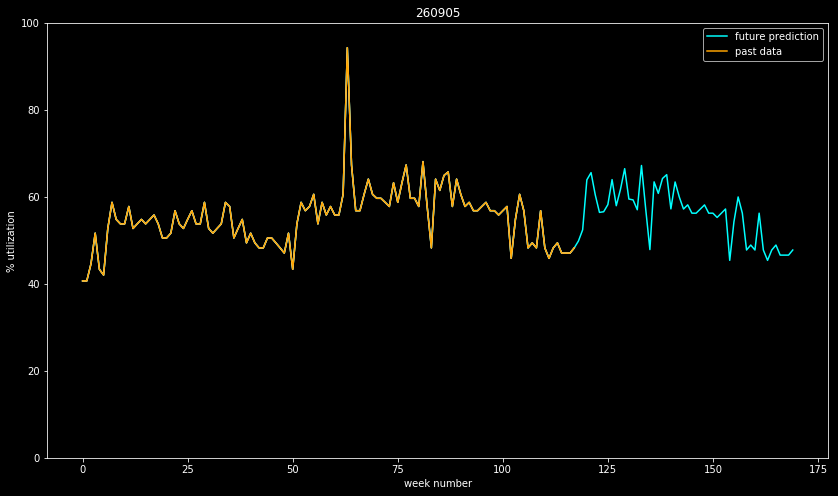

Error of model # 4  =  0.014644150073521213


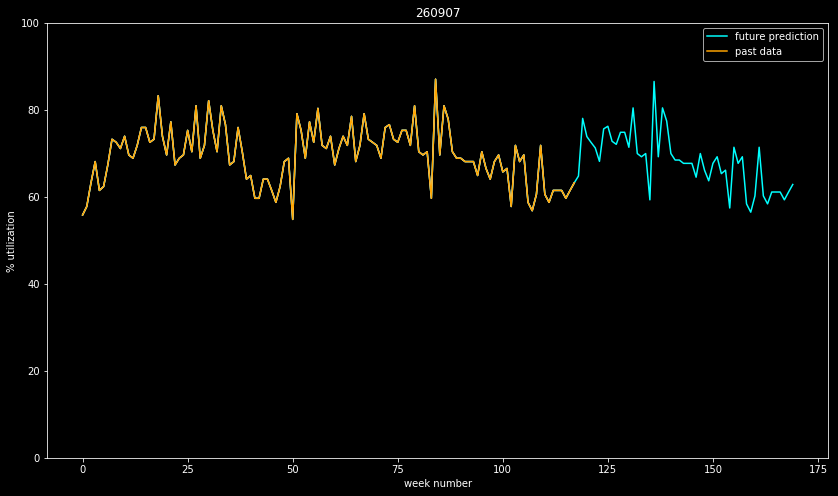

Error of model # 5  =  0.010260321392043163


In [21]:
import pandas
from matplotlib.backends.backend_pdf import PdfPages
pp = PdfPages('multipage.pdf')

## Prototyping ##
 
# Global Variables 
p_values = [0,1,2,4]
d_values = [0, 1]
q_values = [0, 1]
warnings.filterwarnings("ignore")

minimume_size = 104
count = 0

# Filter sites
for site_identifier, historic_data in cell_sites:
    new_row = [site_identifier]
    num_data_points = historic_data.shape[0]
    result = 0
    results_dict[site_id].append(site_identifier)
    
    if num_data_points < minimume_size:
        for i in range(1, num_predictions+1):
            column_name = week + str(i)
            # Fill column names with zero
            results_dict[column_name].append(0)
        # Fill accuracy column with na
        results_dict[accuracy].append('na')
    else:
        ## LOG TIME SERIES
        timeseries = historic_data.loc[:, utilization].apply(lambda x: math.log(x))
        X = timeseries.values
         
        days_in_year = 52
        differenced = difference(X, days_in_year)
        differenced_2 = difference(differenced)  # Second order difference

        order, error = evaluate_models(differenced, p_values, d_values, q_values)
        
        # fit model
        # PARAMS = (12,0 3)
        model = ARIMA(differenced, order=order)
        model_fit = model.fit(disp=0)
        
        # multi-step out-of-sample forecast
        start_index = len(differenced)
        end_index = start_index + (num_predictions-1)
        forecast = model_fit.predict(start=start_index, end=end_index)  

        # invert the differenced forecast to something usable
        history = [x for x in X]
        predictions = []
        day = 1
        for yhat in forecast:
            inverted = inverse_difference(history, yhat, days_in_year)
            history.append(inverted)
            
        ## Find inverse-log to get back to original scale
        history = np.exp(history)
        
        ## Logic for printing daily predictions to csv file
        for i in range(1, num_predictions+1):
            column_name = week + str(i)
            # Fill column names with zero
            results_dict[column_name].append(history[i-1])
            
        results_dict[accuracy].append(error)
        rng = pd.date_range(timeseries.index[-1], periods=1 + num_predictions, freq='W')
        create_plot(history, historic_data, site_identifier)
        
    ## Stop this loop early
    # The real application produces
    # 5,000+ predictions
    count = count + 1
    if(count > 4):
        break

In [93]:
# Conver results_dict into a dataframe, set the index to 'site number', drop the 'site number column'
results_df = pd.DataFrame(results_dict)
site_id_column = results_df.loc[:, site_id]
results_df = results_df.set_index(site_id_column)
results_df = results_df.drop(site_id, axis=1)
results_df.to_csv('Report.csv')